## Sentiment Analysis of English Texts

### Approach 1: Naive Bayes

#### Importing required libraries

In [63]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer

# Downloading necessary datasets from NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Machine Learning libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srays/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\srays/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\srays/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\srays/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Loading the dataset

In [2]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### Exploratory Data Analysis(EDA)

In [7]:
# Shape of the dataset
print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

# Statistical figures about the dataset
print("Statistical figures: ")
print(df.describe())

# Count and types of sentiments
print(f"There are {df['airline_sentiment'].nunique()} sentiments in this dataset and they are: ")
for i in range(df['airline_sentiment'].nunique()):
    print(f"{i+1}. {df['airline_sentiment'].unique()[i]}")

This dataset has 14640 rows and 15 columns.
Statistical figures: 
           tweet_id  airline_sentiment_confidence  negativereason_confidence  \
count  1.464000e+04                  14640.000000               10522.000000   
mean   5.692184e+17                      0.900169                   0.638298   
std    7.791112e+14                      0.162830                   0.330440   
min    5.675883e+17                      0.335000                   0.000000   
25%    5.685592e+17                      0.692300                   0.360600   
50%    5.694779e+17                      1.000000                   0.670600   
75%    5.698905e+17                      1.000000                   1.000000   
max    5.703106e+17                      1.000000                   1.000000   

       retweet_count  
count   14640.000000  
mean        0.082650  
std         0.745778  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        44.000000  
There 

#### Visualizing the dataset

C:\Users\srays\AppData\Local\Temp\ipykernel_10844\2377378644.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, x = df['airline_sentiment'], palette = 'viridis')


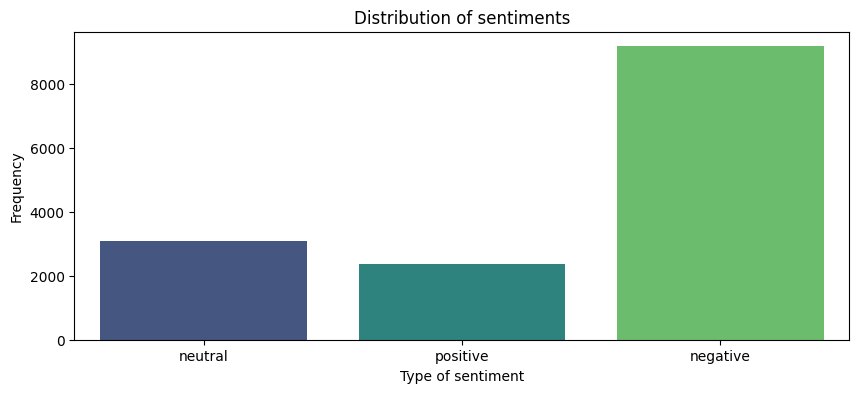

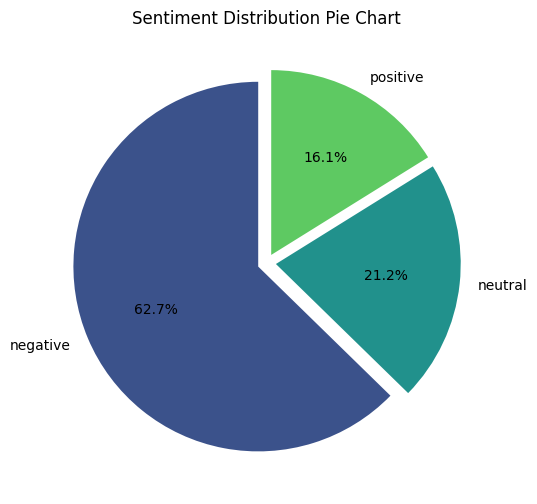

In [22]:
# Frequency plot
plt.figure(figsize = (10, 4))
sns.countplot(data = df, x = df['airline_sentiment'], palette = 'viridis')
plt.title('Distribution of sentiments')
plt.xlabel('Type of sentiment')
plt.ylabel('Frequency')
plt.show()

# Pie chart
plt.figure(figsize = (6, 6))
df['airline_sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', 3), startangle=90, explode=[0.05]*3)
plt.title('Sentiment Distribution Pie Chart')
plt.ylabel('')
plt.show()

#### Text Preprocessing

##### Data Cleaning

In [24]:
def clean_data(text):    
    # Convert to lowercase
    text = text.lower()
    
    # Tie "not" with the next word to retain the negative sentiment
    text = re.sub(r'\bnot\b \b\w+\b', lambda x: x.group().replace(' ', '_'), text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Apply cleaning and fix contractions
df['text'] = df['text'].apply(lambda x: contractions.fix(x))
df['clean_text'] = df['text'].apply(clean_data)

# Display cleaned text
df[['text', 'clean_text']].head()

,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you have added commercials...,plus you have added commercials to the experie...
2,@VirginAmerica I did not today... Must mean I ...,did not_today must mean need to take another trip
3,@VirginAmerica it is really aggressive to blas...,it is really aggressive to blast obnoxious ent...
4,@VirginAmerica and it is a really big bad thin...,and it is really big bad thing about it


##### Tokenization, Lemmatization and Removing Stopwords

In [34]:
# Initialize the lemmatizer object
wnl = WordNetLemmatizer()

# Helper function to map POS tag to wordnet POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
    
# Lemmatization function
def lemmatize(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in set(stopwords.words('english'))]
    pos_tagged = nltk.pos_tag(filtered_words)
    lemmatized_words = [wnl.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tagged]
    return " ".join(lemmatized_words)

# Apply lemmatization to the 'text' column
df['lemmatized_text'] = df['clean_text'].apply(lemmatize)

df[['text', 'clean_text', 'lemmatized_text', 'airline_sentiment']].head()

,text,clean_text,lemmatized_text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,what said,say,neutral
1,@VirginAmerica plus you have added commercials...,plus you have added commercials to the experie...,plus added commercial experience tacky,positive
2,@VirginAmerica I did not today... Must mean I ...,did not_today must mean need to take another trip,not_today must mean need take another trip,neutral
3,@VirginAmerica it is really aggressive to blas...,it is really aggressive to blast obnoxious ent...,really aggressive blast obnoxious entertainmen...,negative
4,@VirginAmerica and it is a really big bad thin...,and it is really big bad thing about it,really big bad thing,negative


#### Vectorization (using TF-IDF)

In [65]:
# Define the input feature
X = df['lemmatized_text']

# Initialize the TF-IDF vectorizer
vec = TfidfVectorizer(ngram_range = (1, 5), max_df = 0.95, min_df = 2, max_features = 10000)

# Convert the lemmatized text to a TF-IDF matrix
X = vec.fit_transform(X)

#### Label encoding of sentiments

In [66]:
y = df['airline_sentiment'].map({'negative':0, 'neutral':1, 'positive':2})

#### Splitting the dataset

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Initializing and training the model

In [71]:
# Initialize the Naive Bayes classifier
nb_model = MultinomialNB(alpha = 0.1)

# Train the model on the training data
nb_model.fit(X_train, y_train)

# Hyperparameter tuning
param_grid = {'alpha': [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.0005, 0.05, 0.5, 1, 1.5, 2]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv = 5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'alpha': 0.1}


#### Making predictions on the test data

In [72]:
y_pred = nb_model.predict(X_test)

#### Evaluating the model

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.93      0.86      1889
     Neutral       0.63      0.40      0.49       580
    Positive       0.79      0.59      0.68       459

    accuracy                           0.78      2928
   macro avg       0.74      0.64      0.68      2928
weighted avg       0.76      0.78      0.76      2928



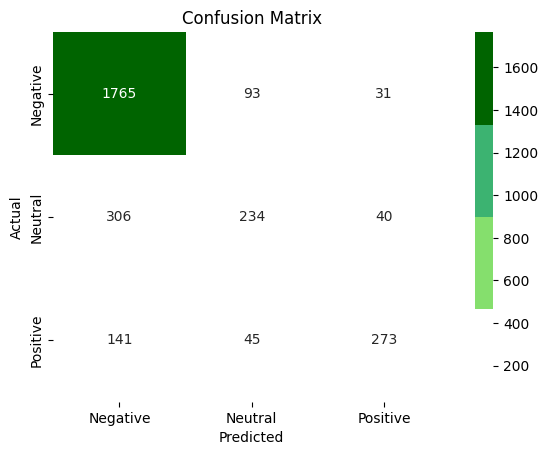

Accuracy: 77.60%


In [73]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmap = mat.colors.ListedColormap(['#ffffff', '#85df6d', '#3cb371', '#006400'])

sns.heatmap(cm, annot = True, fmt = 'd', cmap = cmap,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate the accuracy score
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

In [ ]:
# Taking custom input
message = input()

# Data preprocessing and vectorization
message = lemmatize(clean_data(message))
message = vec.transform([message])

# Displaying prediction
pred = nb_model.predict(message)

match pred:
    case 0:
        print('negative')
    case 1:
        print('neutral')
    case 2:
        print('positive')